In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Diet Plan Recommendations

### Loading Dataset

In [2]:
df_train = pd.read_csv('diet_plan_train_dataset.csv')
df_train

,age,gender,bmi,activity_level,calories_to_maintain_weight
0,44,M,35.305202,1.3,2432.9201
1,12,M,14.808755,1.5,1897.8195
2,33,F,27.652338,1.7,2523.4307
3,16,F,20.654095,1.5,2041.6095
4,31,M,28.122479,1.3,2205.0613
...,...,...,...,...,...
10185,12,M,17.214291,1.3,1603.6007
10186,14,M,21.135759,1.2,1805.5224
10187,6,M,12.477581,1.9,1842.4072
10188,20,F,21.441534,1.9,2636.4381


In [3]:
df_test = pd.read_csv('diet_plan_test_dataset.csv')
df_test

,age,gender,bmi,activity_level,calories_to_maintain_weight
0,3.0,F,16.597151,1.9,1876.0524
1,4.0,F,17.227739,1.9,1767.4104
2,3.0,M,14.220153,1.9,1520.3876
3,3.0,F,19.988219,1.3,1212.3111
4,4.0,F,19.994058,1.7,1596.3289
...,...,...,...,...,...
531,50.0,F,36.751454,1.2,1965.5940
532,60.0,F,35.846570,1.5,2352.2685
533,58.0,M,35.886027,1.2,2155.5480
534,84.0,F,36.919486,1.5,2220.2235


### Copying Data to Variable

In [4]:
diet_features_train = df_train.copy()
diet_features_test = df_test.copy()

diet_label_train = diet_features_train.pop('calories_to_maintain_weight')
diet_label_test = diet_features_test.pop('calories_to_maintain_weight')

In [5]:
print(diet_features_train)
print(diet_features_test)

       age gender        bmi  activity_level
0       44      M  35.305202             1.3
1       12      M  14.808755             1.5
2       33      F  27.652338             1.7
3       16      F  20.654095             1.5
4       31      M  28.122479             1.3
...    ...    ...        ...             ...
10185   12      M  17.214291             1.3
10186   14      M  21.135759             1.2
10187    6      M  12.477581             1.9
10188   20      F  21.441534             1.9
10189   28      M  25.593436             1.2

[10190 rows x 4 columns]
      age gender        bmi  activity_level
0     3.0      F  16.597151             1.9
1     4.0      F  17.227739             1.9
2     3.0      M  14.220153             1.9
3     3.0      F  19.988219             1.3
4     4.0      F  19.994058             1.7
..    ...    ...        ...             ...
531  50.0      F  36.751454             1.2
532  60.0      F  35.846570             1.5
533  58.0      M  35.886027           

In [6]:
print(diet_label_train)
print(diet_label_test)

0        2432.9201
1        1897.8195
2        2523.4307
3        2041.6095
4        2205.0613
           ...    
10185    1603.6007
10186    1805.5224
10187    1842.4072
10188    2636.4381
10189    1951.0572
Name: calories_to_maintain_weight, Length: 10190, dtype: float64
0      1876.0524
1      1767.4104
2      1520.3876
3      1212.3111
4      1596.3289
         ...    
531    1965.5940
532    2352.2685
533    2155.5480
534    2220.2235
535    1821.2784
Name: calories_to_maintain_weight, Length: 536, dtype: float64


### Building Preprocessing Model

In [7]:
inputs = {}

for name, column in diet_features_train.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'gender': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'gender')>,
 'bmi': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bmi')>,
 'activity_level': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'activity_level')>}

In [8]:
# Preprocessing input berjenis numerik
numeric_inputs = {name:input for name, input in inputs.items()
                  if input.dtype == tf.float32}

x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = tf.keras.layers.Normalization()
norm.adapt(np.array(df_train[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'normalization')>

In [9]:
preprocessed_inputs = [all_numeric_inputs]

In [10]:
# Preprocessing input berjenis string
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue

    lookup = tf.keras.layers.StringLookup(
        vocabulary=np.unique(diet_features_train[name])
    )
    one_hot = tf.keras.layers.CategoryEncoding(
        num_tokens=lookup.vocabulary_size()
    )

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

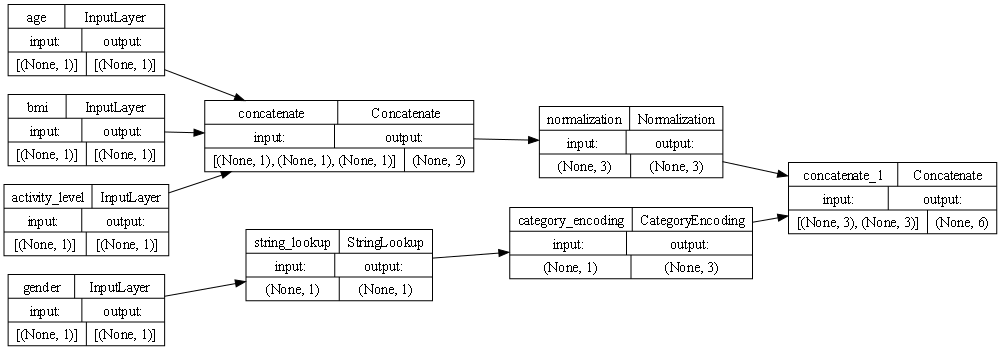

In [11]:
preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)
diet_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)
tf.keras.utils.plot_model(
    model=diet_preprocessing,
    rankdir="LR",
    dpi=72,
    show_shapes=True
)

In [12]:
diet_features_train_dict = {name: np.array(value)
                      for name, value in diet_features_train.items()}
diet_features_test_dict = {name: np.array(value)
                           for name, value in diet_features_test.items()}

In [13]:
features_dict = {name: values[:1]
                 for name, values in diet_features_train_dict.items()}
diet_preprocessing(features_dict)

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 0.9465797,  1.5135044, -0.7833693,  0.       ,  0.       ,
         1.       ]], dtype=float32)>

### Build the Model

In [14]:
def create_model(body, preprocessed_head):
    preprocessed_head = diet_preprocessing(inputs)
    result = body(preprocessed_head)
    model = tf.keras.Model(inputs, result)

    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mae'])
    
    return model

In [15]:
model_body = tf.keras.Sequential([
    tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

model = create_model(model_body, preprocessed_inputs)

init_weights = model.get_weights()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 activity_level (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 bmi (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 gender (InputLayer)            [(None, 1)]          0           []                               
                                                                                            

#### Choosing Learning Rate

In [16]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.LogCosh(), optimizer=optimizer, metrics=['mae'])

history = model.fit(diet_features_train_dict, diet_label_train, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
319/319 [==============================] - 3s 4ms/step - loss: 2118.1489 - mae: 2118.4399 - lr: 1.0000e-05
Epoch 2/50
319/319 [==============================] - 1s 4ms/step - loss: 2118.0002 - mae: 2118.2917 - lr: 1.1220e-05
Epoch 3/50
319/319 [==============================] - 1s 4ms/step - loss: 2117.8311 - mae: 2118.1223 - lr: 1.2589e-05
Epoch 4/50
319/319 [==============================] - 1s 4ms/step - loss: 2117.6292 - mae: 2117.9221 - lr: 1.4125e-05
Epoch 5/50
319/319 [==============================] - 1s 4ms/step - loss: 2117.3789 - mae: 2117.6702 - lr: 1.5849e-05
Epoch 6/50
319/319 [==============================] - 1s 4ms/step - loss: 2117.0481 - mae: 2117.3418 - lr: 1.7783e-05
Epoch 7/50
319/319 [==============================] - 2s 5ms/step - loss: 2116.5815 - mae: 2116.8726 - lr: 1.9953e-05
Epoch 8/50
319/319 [==============================] - 2s 5ms/step - loss: 2115.8433 - mae: 2116.1328 - lr: 2.2387e-05
Epoch 9/50
319/319 [==============================] - 1s

C:\Users\Karkar\AppData\Local\Temp\ipykernel_3640\3136561456.py:7: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.axis([1e-5, 0, 0, 500])


(1e-05, 0.0037368012538211595, 0.0, 500.0)

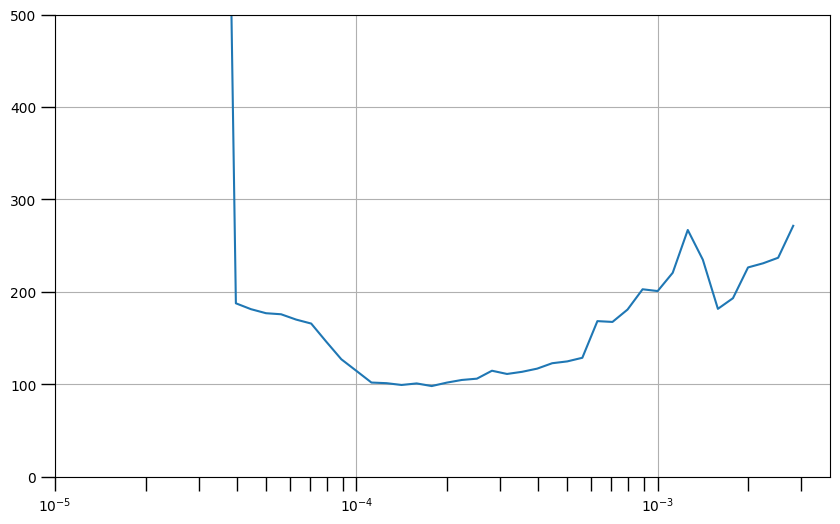

In [17]:
lrs = 1e-5 * (10 ** (np.arange(50) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-5, 0, 0, 500])

#### Traning the Model

In [18]:
tf.keras.backend.clear_session()
model.set_weights(init_weights)

model.compile(loss=tf.keras.losses.LogCosh(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1.5e-4),
              metrics=['mae'])

history = model.fit(x=diet_features_train_dict,
                    y=diet_label_train,
                    validation_data=(diet_features_test_dict, diet_label_test),
                    epochs=100)

Epoch 1/100
319/319 [==============================] - 3s 5ms/step - loss: 2033.2240 - mae: 2033.4301 - val_loss: 1681.5468 - val_mae: 1681.5112
Epoch 2/100
319/319 [==============================] - 1s 4ms/step - loss: 634.1665 - mae: 633.7934 - val_loss: 163.1387 - val_mae: 162.6373
Epoch 3/100
319/319 [==============================] - 2s 5ms/step - loss: 172.6191 - mae: 172.1137 - val_loss: 145.7505 - val_mae: 145.2404
Epoch 4/100
319/319 [==============================] - 2s 6ms/step - loss: 153.3317 - mae: 152.7924 - val_loss: 111.5581 - val_mae: 110.9868
Epoch 5/100
319/319 [==============================] - 2s 5ms/step - loss: 137.2865 - mae: 136.6954 - val_loss: 93.6680 - val_mae: 93.0520
Epoch 6/100
319/319 [==============================] - 2s 5ms/step - loss: 131.0093 - mae: 130.3807 - val_loss: 88.8075 - val_mae: 88.1557
Epoch 7/100
319/319 [==============================] - 2s 5ms/step - loss: 126.3561 - mae: 125.7040 - val_loss: 89.6960 - val_mae: 89.0354
Epoch 8/100
319

(0.0, 100.0, 0.0, 400.0)

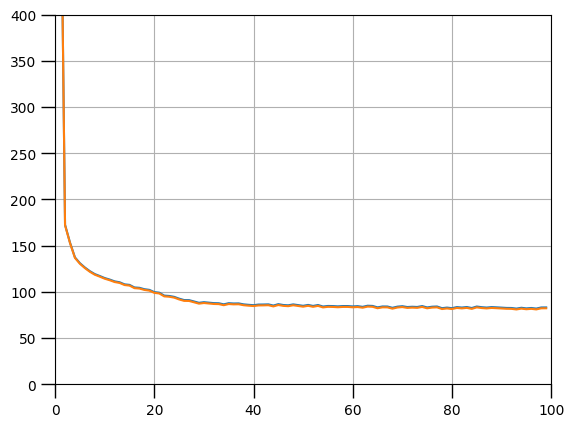

In [19]:
plt.grid(True)
plt.plot(history.history['loss'])
plt.plot(history.history['mae'])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([0, history.params['epochs'], 0, 400])

In [20]:
results = model.predict(diet_features_test_dict)
result_errors = tf.keras.metrics.mean_absolute_error(diet_label_test, results).numpy()
selisih = (results.reshape((-1)) - diet_label_test).abs()

print('MAE')
print(f'Mean: {result_errors.mean()}')
print(f'Min: {result_errors.min()}')
print(f'Max: {result_errors.max()}')
print(f'Standar Deviasi: {result_errors.std()}')

print('Selisih')
print(f'Mean: {selisih.mean()}')
print(f'Min: {selisih.min()}')
print(f'Max: {selisih.max()}')
print(f'Standar Deviasi: {selisih.std()}')

17/17 [==============================] - 0s 3ms/step
MAE
Mean: 422.29766845703125
Min: 300.675537109375
Max: 877.3251953125
Standar Deviasi: 131.4354705810547
Selisih
Mean: 33.85433037036497
Min: 0.14461015625010987
Max: 331.88637109374986
Standar Deviasi: 42.776992439850915


In [21]:
results

array([[1778.0176],
       [1838.3917],
       [1441.8065],
       [1243.5504],
       [1671.2014],
       [1387.1399],
       [1607.6713],
       [1738.201 ],
       [1487.198 ],
       [1902.1671],
       [1297.1621],
       [1602.6353],
       [1345.8271],
       [1418.7524],
       [1768.268 ],
       [1751.4432],
       [1686.8218],
       [1337.9429],
       [1443.2997],
       [1535.9297],
       [1420.6055],
       [1571.708 ],
       [1767.3834],
       [1516.7631],
       [1637.4753],
       [1632.17  ],
       [1695.1395],
       [1648.2399],
       [1857.4231],
       [1301.8087],
       [1804.976 ],
       [1887.5708],
       [1515.677 ],
       [1848.6128],
       [1420.8663],
       [1410.8583],
       [1763.4406],
       [1762.8615],
       [1349.4042],
       [1635.1373],
       [1595.401 ],
       [1605.4266],
       [1571.9982],
       [1638.712 ],
       [1632.4717],
       [1722.4103],
       [1610.0548],
       [1375.9944],
       [1624.183 ],
       [1852.3413],


In [22]:
result_errors

array([407.61707, 373.8947 , 683.37494, 877.3252 , 483.16367, 736.5749 ,
       532.0455 , 435.0798 , 640.0269 , 347.53656, 824.71375, 536.1867 ,
       776.95654, 705.788  , 414.14166, 425.7189 , 471.88052, 784.6938 ,
       681.92645, 594.51855, 703.98346, 562.5224 , 414.74103, 612.30914,
       508.20767, 512.3662 , 465.89053, 500.07404, 365.67517, 820.1538 ,
       391.15186, 353.31104, 613.32227, 369.40533, 703.7294 , 713.47595,
       417.43335, 417.82877, 773.44635, 510.03094, 542.1875 , 533.8819 ,
       562.2679 , 507.25345, 512.1276 , 446.33798, 530.09973, 747.42926,
       518.7154 , 367.81934, 603.1116 , 672.49316, 405.26343, 570.67535,
       552.33203, 424.32568, 388.60803, 542.4713 , 380.05835, 390.7201 ,
       503.8011 , 620.52563, 485.42154, 540.3062 , 395.     , 309.07938,
       538.78986, 529.486  , 406.12256, 352.20908, 590.1111 , 349.80112,
       358.14526, 562.75397, 357.3469 , 400.0531 , 586.1684 , 405.372  ,
       529.8254 , 382.7707 , 370.47067, 369.97778, 

### Save Model

In [40]:
model.save('diet_plan_model.h5')

#### Convert to TFLite

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Karkar\AppData\Local\Temp\tmpb2cl1p89\assets


INFO:tensorflow:Assets written to: C:\Users\Karkar\AppData\Local\Temp\tmpb2cl1p89\assets


In [41]:
import pathlib

tflite_models_dir = pathlib.Path("diet-plan-model/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"diet_plan_model.tflite"
tflite_model_file.write_bytes(tflite_model)

59320

In [42]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_file = tflite_models_dir/"diet_plan_model.tflite"
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Karkar\AppData\Local\Temp\tmplg3dgk53\assets


INFO:tensorflow:Assets written to: C:\Users\Karkar\AppData\Local\Temp\tmplg3dgk53\assets


59320

### Interpret TFLite Model

In [44]:
interpreter = tf.lite.Interpreter(model_path='diet-plan-model\\diet_plan_model.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()
output_index = interpreter.get_output_details()[0]['index']

In [45]:
for item in input_index:
    print(item)
print(interpreter.get_output_details())

{'name': 'serving_default_activity_level:0', 'index': 0, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'serving_default_age:0', 'index': 1, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'serving_default_bmi:0', 'index': 2, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'serving_de

In [46]:
test_dict = {name: np.expand_dims(values[:1], axis=0)
                 for name, values in diet_features_test_dict.items()}
#preprocessed_test = diet_preprocessing(test_dict)
#print(preprocessed_test)
print(test_dict)

{'age': array([[3.]]), 'gender': array([['F']], dtype=object), 'bmi': array([[16.59715123]]), 'activity_level': array([[1.9]])}


In [47]:
# Dictionary itu struktur data yang tidak terurut, jadi nilai input
# dimasukkan secara manual
interpreter.set_tensor(input_index[0]['index'], test_dict['activity_level'].astype(np.float32))
interpreter.set_tensor(input_index[1]['index'], test_dict['age'].astype(np.float32))
interpreter.set_tensor(input_index[2]['index'], test_dict['bmi'].astype(np.float32))
interpreter.set_tensor(input_index[3]['index'], test_dict['gender'])
interpreter.invoke()
output = interpreter.get_tensor(output_index)

In [48]:
print(output)
print(diet_label_train.iloc[0])

[[1772.6542]]
2432.9201000000003
